<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#The-mulearn.fuzzifier-module" data-toc-modified-id="The-mulearn.fuzzifier-module-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>The <code>mulearn.fuzzifier</code> module</a></span></li></ul></div>

# The `mulearn.fuzzifier` module 

> The `mulearn.fuzzifier` module contains the implementations of fuzzifiers.

In [ ]:
# export

import numpy as np
import matplotlib.pyplot as plt
import pytest
from scipy.optimize import curve_fit

In [ ]:
# default_exp fuzzifier

In [ ]:
#hide
from nbdev.showdoc import show_doc

In [ ]:
# export

class Fuzzifier:
    def __init__(self, xs=None, mus=None):
        self.xs = xs
        self.mus = mus

    def get_r_to_mu(self,
                    sq_radius, # was SV_square_distance
                    x_to_sq_dist): # was estimated_square_distance_from_center
        '''Transforms the square distance between center of the learnt sphere
        and the image of a point in original space into the membership degree
        of the latter to the induced fuzzy set.
        
        Not implemented in the base fuzzifier class.
        
        - `sq_radius`: squared radius of the learnt sphere (float).
        
        - `x_to_sq_dist`: mapping of a point in original space into the
          square distance of its image from the center of the learnt sphere
          (function).
        '''
        
        raise NotImplementedError(
        'the base class does not implement get_r_to_mu method')

    def get_fuzzified_membership(self,
                                 sq_radius, # was SV_square_distance
                                 x_to_sq_dist, # was estimated_square_distance_from_center
                                 return_profile=False):
        '''Return the induced membership function.
        
        - `sq_radius`: squared radius of the learnt sphere (float).
        
        - `x_to_sq_dist`: mapping of a point in original space into the
          square distance of its image from the center of the learnt sphere
          (function).
        
        - `return_profile` flag triggering the generation of the graph
          of the fuzzifier to be returned alongside the fuzzifier itself
          (bool, default=False).

        Returns a list containing
        
        - the membership function if `return_profile` is `False`, and
        - the membership function and the salient coordinates of the graph of
          the fuzzifier if `return_profile` is `True`.
        '''
        r_to_mu = self.get_r_to_mu(sq_radius, x_to_sq_dist)
        
        def estimated_membership(x):
            r = x_to_sq_dist(np.array(x))
            return r_to_mu(r)

        result = [estimated_membership]

        if return_profile:
            rdata = list(map(x_to_sq_dist, self.xs))
            rdata_synth = np.linspace(0, max(rdata)*1.1, 200)
            estimate = list(map(r_to_mu, rdata_synth))
            result.append([rdata, rdata_synth, estimate])

        return result
    
    def __str__(self):
        return self.__repr__()

    def __eq__(self, other):
        return type(self) == type(other)

    def __ne__(self, other):
        return not self == other

    def __hash__(self):
        return hash(self.__repr__())

    def __nonzero__(self):
        return True

The base class for fuzzifiers is `Fuzzifier`: it exposes a basic constructor
which is called from the subclasses, and two methods `get_r_to_mu` returning
a mapping that transforms a point from the original space onto the feature
space, subsequently computing the distance of the image w.r.t. the center
of the learnt sphere, and `get_fuzzified_membership` returning the membership
function inferred from data, possibly alongside informations enabling to
draw the graph of the fuzzifier.

In [ ]:
# export

class CrispFuzzifier(Fuzzifier):
    def __init__(self, xs=None, mus=None, profile='fixed'):
        r'''Creates an instance of `CrispFuzzifier`
        
        - `xs`: objects in training set (iterable).
        
        - `ys`: degree memberships in training set (iterable).
        
        - `profile`: method to be used in order to fix the fuzzifier
          threshold ('fixed' used the sphere radius, 'infer' fits using
          data in `self.xs` and `self.mus`.
        '''
        
        super().__init__(xs, mus)
        self.profile = profile
        if profile not in ['fixed', 'infer']:
            raise ValueError(f"'profile' parameter should be equal to "
                             "'fixed' or 'infer' (provided value: {profile})")
            
        if profile == 'infer' and (xs is None or mus is None):
            raise ValueError(f"all arguments to the constructor of "
                             "CrispFuzzifier should be specified when "
                             "profile='infer'")

        self.name = 'Crisp'
        self.latex_name = '$\\hat\\mu_{\\text{crisp}}$'

    def get_r_to_mu(self, sq_radius, x_to_sq_dist):
        r'''Returns a function that transforms the square distance between
        center of the learnt sphere and the image of a point in original
        space into a crisp membership degree having the form
        
        $$ \mu(r) = \begin{cases}
          1 & \text{if $r \leq r_\text{crisp}$,} \\
          0 & \text{otherwise.}
        \end{cases}$$   
        
        The threshold is set to the learnt square radius of the sphere if the
        `profile` attribute of the class have been set to `fixed`, and
        induced via interpolation of the `xs` and `mus` attributes when it is
        has been set to `infer`.
        
        **Note** This function is meant to be called internally by the
        `get_fuzzified_membership` method in the base `Fuzzifier` class.
        
        - `sq_radius`: squared radius of the learnt sphere (float).
        
        - `x_to_sq_dist`: mapping of a point in original space into the
          square distance of its image from the center of the learnt sphere
          (function).
        '''
        
        if self.profile == 'fixed':
            return lambda r: 1 if r <= sq_radius else 0
            
        elif self.profile == 'infer':
            rdata = np.fromiter(map(x_to_sq_dist, self.xs), dtype=float)

            def r_to_mu_prototype(r, r_crisp):
                result = np.ones(len(r))
                result[r > r_crisp] = 0
                return result


            popt, _ = curve_fit(r_to_mu_prototype, rdata, self.mus)
                                # bounds=((0,), (np.inf,)))

            if popt[0] < 0:
                raise ValueError('Profile fitting returned a negative parameter')
            return lambda r: r_to_mu_prototype([r], *popt)[0]
        else:
            raise ('This should never happen. '
                   'Check CrispFuzzifier constructor.')

    def __repr__(self):
        xs_repr = self.xs.__repr__()
        mus_repr = self.mus.__repr__()
        self_repr = f'CrispFuzzifier({xs_repr}, {mus_repr}'
        if self.profile != 'fixed':
            self_repr += f', profile={self.profile}'
        self_repr += ')'
        return self_repr

Fuzzifier corresponding to a crisp (classical) set: membership is equal to 1
within the learnt sphere and equal to 0 outside it.

In [ ]:
show_doc(CrispFuzzifier.__init__)

<h4 id="CrispFuzzifier.__init__" class="doc_header"><code>CrispFuzzifier.__init__</code><a href="__main__.py#L4" class="source_link" style="float:right">[source]</a></h4>

> <code>CrispFuzzifier.__init__</code>(**`xs`**=*`None`*, **`mus`**=*`None`*, **`profile`**=*`'fixed'`*)

Creates an instance of [`CrispFuzzifier`](/mulearn/fuzzifiers#CrispFuzzifier)

- `xs`: objects in training set (iterable).

- `ys`: degree memberships in training set (iterable).

- `profile`: method to be used in order to fix the fuzzifier
  threshold ('fixed' used the sphere radius, 'infer' fits using
  data in `self.xs` and `self.mus`.

A crisp fuzzifier can be created etiher without arguments or specifying
objects and labels of a training set.

In [ ]:
cf_1 = CrispFuzzifier()
cf_2 = CrispFuzzifier([1, 2, 5, 5.5, 7, 8, 9.5, 10],
                      [1, 1, 1, 0.9, 0.4, 0.1, 0, 0])

The optional parameter `profile` defines the procedure to be used in order
to choose the thresholding value in the fuzzifier, it can either be set to
`'fixed'` or `'infer'` (see the description of `get_r_to_mu` later on).
Specifying a different value will raise an exception. The same will happen
if `profile='infer'` and the training set has not been specified as argument
to the constructor.

In [ ]:
show_doc(CrispFuzzifier.get_r_to_mu)

<h4 id="CrispFuzzifier.get_r_to_mu" class="doc_header"><code>CrispFuzzifier.get_r_to_mu</code><a href="__main__.py#L30" class="source_link" style="float:right">[source]</a></h4>

> <code>CrispFuzzifier.get_r_to_mu</code>(**`sq_radius`**, **`x_to_sq_dist`**)

Returns a function that transforms the square distance between
center of the learnt sphere and the image of a point in original
space into a crisp membership degree having the form

$$ \mu(r) = \begin{cases}
  1 & \text{if $r \leq r_\text{crisp}$,} \\
  0 & \text{otherwise.}
\end{cases}$$   

The threshold is set to the learnt square radius of the sphere if the
`profile` attribute of the class have been set to `fixed`, and
induced via interpolation of the `xs` and `mus` attributes when it is
has been set to `infer`.

**Note** This function is meant to be called internally by the
`get_fuzzified_membership` method in the base [`Fuzzifier`](/mulearn/fuzzifiers#Fuzzifier) class.

- `sq_radius`: squared radius of the learnt sphere (float).

- `x_to_sq_dist`: mapping of a point in original space into the
  square distance of its image from the center of the learnt sphere
  (function).

In its basic version, the method returns a function associating a generic
square distance from the learnt sphere center to a membership degree.

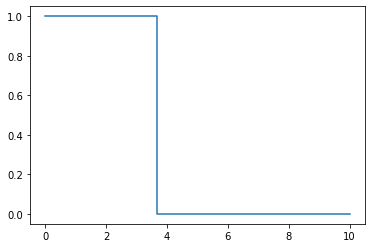

In [ ]:
cf = CrispFuzzifier([1, 2, 5, 5.5, 7, 8, 9.5, 10],
                    [1, 1, 1, 0.9, 0.4, 0.1, 0, 0])
mu = cf.get_r_to_mu(4, lambda x: x)

r = np.linspace(0, 10, 20)
plt.step(r, list(map(mu, r)))
plt.show()

In [ ]:
show_doc(CrispFuzzifier.get_fuzzified_membership)

<h4 id="Fuzzifier.get_fuzzified_membership" class="doc_header"><code>Fuzzifier.get_fuzzified_membership</code><a href="__main__.py#L27" class="source_link" style="float:right">[source]</a></h4>

> <code>Fuzzifier.get_fuzzified_membership</code>(**`sq_radius`**, **`x_to_sq_dist`**, **`return_profile`**=*`False`*)

Return the induced membership function.

- `sq_radius`: squared radius of the learnt sphere (float).

- `x_to_sq_dist`: mapping of a point in original space into the
  square distance of its image from the center of the learnt sphere
  (function).

- `return_profile` flag triggering the generation of the graph
  of the fuzzifier to be returned alongside the fuzzifier itself
  (bool, default=False).

Returns a list containing

- the membership function if `return_profile` is `False`, and
- the membership function and the salient coordinates of the graph of
  the fuzzifier if `return_profile` is `True`.

`CrispFuzzifier` implements this method in order to return a threshold
function. The thresholding value is fixed by default using the radius of
the learnt sphere.

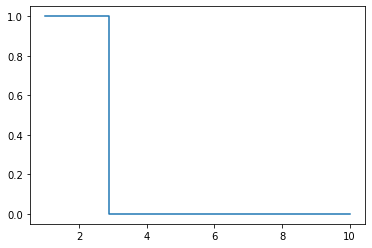

In [ ]:
cf = CrispFuzzifier([1, 2, 5, 5.5, 7, 8, 9.5, 10],
                    [1, 1, 1, 0.9, 0.4, 0.1, 0, 0])
[mu] = cf.get_fuzzified_membership(1, lambda x: x/3)

x = np.linspace(1, 10, 20)
plt.step(x, list(map(mu, x)))
plt.show()

Setting `profile='infer'` will perform an interpolation process fitting
the threshold to the training set passed to the constructor.

/home/malchiodi/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


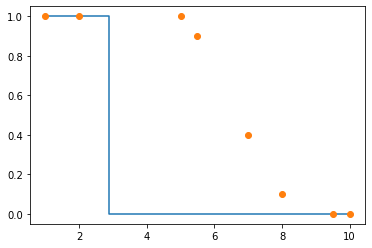

In [ ]:
xs = [1, 2, 5, 5.5, 7, 8, 9.5, 10]
mus = [1, 1, 1, 0.9, 0.4, 0.1, 0, 0]
cf = CrispFuzzifier(xs,mus, profile='infer')
[mu] = cf.get_fuzzified_membership(2, lambda x: x/3)

x = np.linspace(1, 10, 20)
plt.step(x, list(map(mu, x)))
plt.plot(xs, mus, 'o')
plt.show()

The `return_profile` optional argument returns a further list that contains
- a list of the squared distances between the images of points in the
  training set and the center of the sphere;
- a list of synthesized values for such distances (spanned uniformely
  between the minimum and maximum values of the distances within the
  training set);
- a list of membership values associated to the values in previous point.

This new information allow for drawing a profile of the membership function
as a function of the distance in feature space.

/home/malchiodi/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


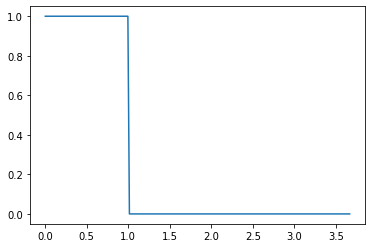

In [ ]:
[mu, [rdata, rdata_synth, estimate]] = \
      cf.get_fuzzified_membership(1, lambda x: x/3, return_profile=True)

plt.plot(rdata_synth, estimate)
plt.show()

**Tests**

In [ ]:
with pytest.raises(ValueError):
    cf = CrispFuzzifier(profile='infer')
    
with pytest.raises(ValueError):
    cr = CrispFuzzifier(profile='xxx')

In [ ]:
#export

class LinearFuzzifier(Fuzzifier):
    def __init__(self, xs=None, mus=None, profile='infer'):
        r'''Creates an instance of `LinearFuzzifier`
        
        - `xs`: objects in training set (iterable).
        
        - `ys`: degree memberships in training set (iterable).
        
        - `profile`: method to be used in order to fix the fuzzifier
          threshold ('fixed' used the sphere radius, 'infer' fits using
          data in `self.xs` and `self.mus`.
        '''
        
        super().__init__(xs, mus)
        
        if profile not in ['fixed', 'infer']:
            raise ValueError(f"'profile' parameter should be equal to "
                             "'fixed' or 'infer' (provided value: {profile})")
        self.profile = profile
        
        self.name = 'Linear'
        self.latex_name = '$\\hat\\mu_{\\text{lin}}$'
        

    def get_r_to_mu(self,
                    sq_radius, # was SV_square_distance
                    x_to_sq_dist): #was estimated_square_distance_from_center
        r'''Returns a function that transforms the square distance between
        center of the learnt sphere and the image of a point in original
        space into a crisp membership degree having the form
        
        $$ \mu(r) = \begin{cases}
          1    & \text{if $r \leq r_\text{crisp}$,} \\
          l(r) & \text{otherwise,}
        \end{cases}$$   
        
        where $l$ is a linear function decreasing from 1 to 0. The slope of
        this linear function is chosen so that the latter contains the point
        (sq_radius, 0.5) if the `profile` attribute of the class
        have been set to `fixed`, and induced via interpolation of the `xs`
        and `mus` attributes when it is has been set to `infer`.
        
        **Note** This function is meant to be called internally by the
        `get_fuzzified_membership` method in the base `Fuzzifier` class.
        
        - `sq_radius`: squared radius of the learnt sphere (float).
        
        - `x_to_sq_dist`: mapping of a point in original space into the
          square distance of its image from the center of the learnt sphere
          (function).
        '''


        rdata = np.fromiter(map(x_to_sq_dist, self.xs), dtype=float)

        r_1_guess = np.median([x_to_sq_dist(x)
                               for x, mu in zip(self.xs, self.mus)
                               if mu>=0.99])
            
        if self.profile == 'fixed':
            def r_to_mu_prototype(r, r_1):
                return [np.clip(1 - 0.5 * (rr-r_1) / (sq_radius - r_1), 0, 1)
                        for rr in r]

            popt, _ = curve_fit(r_to_mu_prototype,
                                rdata, self.mus,
                                p0=(r_1_guess,),
                                bounds=((0,), (np.inf,)))
            
        elif self.profile == 'infer':
            
            def r_to_mu_prototype(r, r_1, r_0):
                return [np.clip(1 - (r_1 - rr) / (r_1 - r_0), 0, 1)
                        for rr in r]

            popt, _ = curve_fit(r_to_mu_prototype,
                                rdata, self.mus,
                                p0=(r_1_guess, 10*sq_radius),
                                bounds=((0, 0), (np.inf, np.inf,)))
        else:
            raise ValueError('This should never happen.'
                             ' Check LinearFuzzifier constructor.')
        if min(popt) < 0:
            raise ValueError('Profile fitting returned a negative parameter')

        return lambda r: r_to_mu_prototype([r], *popt)[0]


    def __repr__(self):
        xs_repr = self.xs.__repr__()
        mus_repr = self.mus.__repr__()
        self_repr = f'LinearFuzzifier({xs_repr}, {mus_repr}'
        if self.profile != 'fixed':
            self_repr += f', profile={self.profile}'
        self_repr += ')'
        return self_repr
